In [9]:
import os
import cv2
import json
import torch
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from glob import glob
import os.path as osp
import torch.nn.functional as F
from sklearn.cluster import KMeans
from torchvision import transforms
from transformers import CLIPModel
from torchvision import transforms
from argparse import ArgumentParser
from utils_dir.backbones_utils import load_backbone, extract_backbone_features, get_backbone_params, load_backbone_and_tokenizer, prepare_image_for_backbone
from utils_dir.coco_to_seg import coco_to_seg
import matplotlib.pyplot as plt

# Normalization from CoOp
from torchvision.transforms import Normalize
PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]

from build_prototypes import build_object_prototypes
from argparse import ArgumentParser

In [6]:
import json
train_coco = '/home/gridsan/manderson/ovdsat/data/dior/train_coco_subset_N5-1.json'

In [11]:
# Load the JSON file
with open(train_coco, "r") as f:
    data = json.load(f)

# Check if 'images' exists
if "images" in data:
    print("Found 'images' section")

    # Check for a specific item, e.g., file_name = "dog.jpg"
    exists = any(img.get("file_name") == "21589.jpg" for img in data["images"])

    if exists:
        print("Item exists in images ✅")
    else:
        print("Item not found ❌")
else:
    print("'images' key not found in JSON")

Found 'images' section
Item exists in images ✅


In [10]:
parser = ArgumentParser()
parser.add_argument('--data_dir', type=str, default='data/simd_subset_10')
parser.add_argument('--save_dir', type=str, default='/mnt/ddisk/boux/code/ovdsat/run/classification_benchmark_exp')
parser.add_argument('--annotations_file', type=str, default='/mnt/ddisk/boux/code/data/simd/train_coco_subset_N10.json')
parser.add_argument('--backbone_type', type=str, default='dinov2')
parser.add_argument('--target_size', nargs=2, type=int, metavar=('width', 'height'), default=(602, 602))
parser.add_argument('--window_size', type=int, default=224)
parser.add_argument('--scale_factor', type=int, default=1)
parser.add_argument('--num_b', type=int, default=10, help='Number of background samples to extract per image')
parser.add_argument('--k', type=int, default=200, help='Number of background prototypes (clusters for k-means)')
parser.add_argument('--store_bg_prototypes', action='store_true', default=False)

_StoreTrueAction(option_strings=['--store_bg_prototypes'], dest='store_bg_prototypes', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [11]:
DATA_DIR = 'data'
backbone = 'dinov2'
dataset = 'dior'
N=5
M=6

In [12]:
args = parser.parse_args([
    '--data_dir', f'{DATA_DIR}/{dataset}/JPEGImages',
    '--save_dir', f'run/init_prototypes/boxes/{dataset}_N{N}-{M}',
    '--annotations_file', f'{DATA_DIR}/{dataset}/train_coco_subset_N{N}-{M}.json',
    '--backbone_type', backbone,
    '--target_size', '602', '602',
    '--window_size', '224',
    '--scale_factor', '1',
    '--num_b', '10',
    '--k', '200',
    '--store_bg_prototypes'
])

In [15]:
# Convert COCO annotations to segmentation masks
init_data_path = os.path.join('data', 'init_data', args.save_dir.split('/')[-1])
coco_to_seg(args.annotations_file, args.data_dir, init_data_path)

data/init_data/dior_N5-6
data/dior/JPEGImages
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Processed category: groundtrackfield
Processed category: baseballfield
Processed category: bridge
Processed category: Expressway-toll-station
Processed category: vehicle
Processed category: airplane
Processed category: airport
Processed category: tenniscourt
Processed category: trainstation
Processed category: storagetank
Processed category: stadium
Processed category: windmill
Processed category: ship
Processed category: golffield
Processed category: overpass
Processed category: chimney
Processed category: dam
Processed category: basketballcourt
Processed category: harbor
Processed category: Expressway-Service-area
Processing complete.


### Random

In [7]:
init_data_path = 'data/init_data/test-n'
annotations_file = '/home/gridsan/manderson/ovdsat/data/test-n.json'

In [8]:
coco_to_seg(annotations_file, f'{DATA_DIR}/{dataset}/JPEGImages', init_data_path)

data/init_data/test-n
data/dior/JPEGImages
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Processed category: groundtrackfield
Processed category: baseballfield
Processed category: stadium
Processed category: windmill
Processed category: ship
Processed category: golffield
Processed category: overpass
Processed category: chimney
Processed category: dam
Processed category: basketballcourt
Processed category: harbor
Processed category: Expressway-Service-area
Processed category: bridge
Processed category: Expressway-toll-station
Processed category: vehicle
Processed category: airplane
Processed category: airport
Processed category: tenniscourt
Processed category: trainstation
Processed category: storagetank
Processing complete.


In [6]:
# Convert COCO annotations to segmentation masks
init_data_path = os.path.join('data', 'init_data', args.save_dir.split('/')[-1])
coco_to_seg(args.annotations_file, args.data_dir, init_data_path)


# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_backbone(args.backbone_type)
model = model.to(device)
model.eval()
patch_size, _ = get_backbone_params(args.backbone_type)

# Build object prototypes
obj_category_dict = build_object_prototypes(args, model, init_data_path, device, patch_size)

data/init_data/dior_N5-1
data/dior/JPEGImages
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Processed category: groundtrackfield


KeyboardInterrupt: 

### Text (zero-shot)

In [30]:
zero_shot_prot = torch.load('/home/gridsan/manderson/ovdsat/run/text_prototypes/boxes/dior/prototypes_remoteclip-14.pt')

In [32]:
print(zero_shot_prot['prototypes'].shape)

torch.Size([20, 768])


### CoOp

In [6]:
context_path = '/home/gridsan/manderson/ovdsat/CoOp/output/dior/CoOp/vit_l14_remote-ep100-ctx2_5shots/nctx4_cscFalse_ctpmiddle/seed1/prompt_learner/model.pth.tar-100'
model, tokenizer = load_backbone_and_tokenizer('remoteclip-14')

In [7]:
context = torch.load(context_path, map_location=torch.device('cpu'))

In [8]:
print(context.keys())

dict_keys(['state_dict', 'epoch', 'optimizer', 'scheduler', 'val_result'])


In [5]:
print(context['state_dict'].keys())

odict_keys(['ctx', 'token_prefix', 'token_suffix'])


In [9]:
prefix = context['state_dict']['token_prefix']
ctx = context['state_dict']['ctx']
suffix = context['state_dict']['token_suffix']

In [12]:
print(prefix.shape)
print(ctx.shape)
print(suffix.shape)

torch.Size([20, 1, 768])
torch.Size([4, 768])
torch.Size([20, 72, 768])


In [11]:
# # for end, class specific
# prompts = torch.cat(
#     [
#         prefix,  # (n_cls, 1, dim)
#         ctx,     # (n_cls, n_ctx, dim)
#         suffix,  # (n_cls, *, dim)
#     ],
#     dim=1,
# )
# prompts.shape

RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [18]:
classes = ['expressway service area', 'expressway toll station', 'airplane', 'airport', 'background', 'baseball field', 'basketball court', 'bridge', 'chimney', 'dam', 'golf field', 'ground track field', 'harbor', 'overpass', 'ship', 'stadium', 'storage tank', 'tennis court', 'train station', 'vehicle', 'windmill']
for name in classes:
    tokens = len(tokenizer.encode(name))
    print(tokens)
    # token_embed = model.token_embedding(tokens)
    # print(token_embed[:10])

3
3
1
1
1
2
2
1
1
1
2
3
1
1
1
1
2
2
2
1
1


In [15]:
# for middle, unified
classes = ['ground track field', 'baseball field', 'bridge', 'expressway toll station', 'vehicle', 'airplane', 'airport', 'tennis court', 'train station', 'storage tank', 'stadium', 'windmill', 'ship', 'golf field', 'overpass', 'chimney', 'dam', 'basketball court', 'harbor', 'expressway service area']
name_lens = [len(tokenizer.encode(name)) for name in classes]
n_ctx = 4
n_cls = 20

if ctx.dim() == 2:
    ctx = ctx.unsqueeze(0).expand(n_cls, -1, -1)

half_n_ctx = n_ctx // 2
prompts = []
for i in range(n_cls):
    name_len = name_lens[i]
    prefix_i = prefix[i : i + 1, :, :]
    class_i = suffix[i : i + 1, :name_len, :]
    print(class_i.shape)
    suffix_i = suffix[i : i + 1, name_len:, :]
    ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
    ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
    prompt = torch.cat(
        [
            prefix_i,     # (1, 1, dim)
            ctx_i_half1,  # (1, n_ctx//2, dim)
            class_i,      # (1, name_len, dim)
            ctx_i_half2,  # (1, n_ctx//2, dim)
            suffix_i,     # (1, *, dim)
        ],
        dim=1,
    )
    prompts.append(prompt)
prompts = torch.cat(prompts, dim=0)
prompts.shape

torch.Size([1, 3, 768])
torch.Size([1, 2, 768])
torch.Size([1, 1, 768])
torch.Size([1, 3, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 2, 768])
torch.Size([1, 2, 768])
torch.Size([1, 2, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 2, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 2, 768])
torch.Size([1, 1, 768])
torch.Size([1, 3, 768])


torch.Size([20, 77, 768])

In [9]:
text_encoder = model.transformer
text_feats = text_encoder(prompts.to('cpu'))
text_feats.shape

torch.Size([20, 77, 768])

In [10]:
text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats[:, 0, :] #CLS token
text_feats.shape # Final shape of text prototypes should be [n_classes, dim=768]

torch.Size([20, 768])

In [ ]:
coop_classes = ['Ground Track Field', 'Baseball Field', 'Bridge', 'Expressway Toll Station', 'Vehicle', 'Airplane', 'Airport', 'Tennis Court', 'Train Station', 'Storage Tank', 'Stadium', 'Windmill', 'Ship', 'Golf Field', 'Overpass', 'Chimney', 'Dam', 'Basketball Court', 'Harbor', 'Expressway Service Area']

In [ ]:
with open('/home/gridsan/manderson/ovdsat/data/text/dior_labels.txt', "r") as f:
        classes = [line.strip() for line in f]

### Understanding CoOp

In [14]:
import open_clip

In [40]:
n_ctx = 16

In [46]:
classnames = ['airplane', 'boat', 'car']
name_lens = [len(open_clip.tokenize(name)) for name in classnames]
name_lens

[1, 1, 1]

In [47]:
prompt_prefix = " ".join(["X"] * n_ctx)
prompt_prefix

'X X X X X X X X X X X X X X X X'

In [56]:
prompts = [prompt_prefix + " " + name + "." for name in classnames]
print(len(prompts[0]))
prompts # Prompts [n_classes, num_words]

41


['X X X X X X X X X X X X X X X X airplane.',
 'X X X X X X X X X X X X X X X X boat.',
 'X X X X X X X X X X X X X X X X car.']

In [57]:
tokenized_prompts = torch.cat([open_clip.tokenize(p) for p in prompts])
tokenized_prompts.shape # Tokenized prompts [n_classes, num_tokens] (num_tokens usually 77 with padding)

torch.Size([3, 77])

In [64]:
print(tokenized_prompts[0])

tensor([49406,   343,   343,   343,   343,   343,   343,   343,   343,   343,
          343,   343,   343,   343,   343,   343,   343, 16451,   269, 49407,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


In [63]:
with torch.no_grad():
    embedding = model.token_embedding(tokenized_prompts)
embedding.shape # Token embeddings [n_classes, num_tokens, dim]

torch.Size([3, 77, 768])

### CoOp text and object prototype similarity

In [2]:
from CoOp.clip import clip

def load_clip_to_cpu():
    
    backbone_name = 'ViT-L/14'
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url)

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())
    
    ## TODO dont hardcode
    state_dict = torch.load('/home/gridsan/manderson/ovdsat/weights/RemoteCLIP-ViT-L-14.pt', map_location="cpu")
    model = clip.build_model(state_dict)
    model.float()
        
    return model

model = load_clip_to_cpu()

#### Check model

In [22]:
print(model.visual.conv1.weight[0, 0, :5, :5])

tensor([[ 0.0246,  0.0101,  0.0070,  0.0010,  0.0317],
        [ 0.0134, -0.0063, -0.0046, -0.0220,  0.0072],
        [ 0.0094,  0.0019,  0.0021, -0.0181,  0.0063],
        [ 0.0068,  0.0007,  0.0055, -0.0056,  0.0180],
        [ 0.0085, -0.0029,  0.0035, -0.0025,  0.0255]],
       grad_fn=<SliceBackward0>)


In [27]:
print(model.positional_embedding[:5,:5])

tensor([[ 1.9794e-03,  1.9179e-03,  5.7011e-04, -1.6066e-03, -1.2066e-03],
        [ 4.5462e-03,  2.4807e-03,  6.7831e-04, -9.3436e-04,  1.4542e-03],
        [ 1.4329e-03,  1.0798e-03, -1.1206e-03,  1.1391e-03, -2.3782e-04],
        [-7.1420e-05,  1.4675e-03,  1.3108e-03,  9.5170e-05,  4.0867e-03],
        [ 3.5860e-03, -2.0767e-03,  1.2550e-04, -6.6138e-04,  2.6072e-03]],
       grad_fn=<SliceBackward0>)


In [3]:
N = 5
M = 1

coop_prot_path = f'/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/dior_N{N}-{M}/prototypes_remoteclip-14.pt'
coop_prot = torch.load(coop_prot_path)

In [4]:
coop_text_prot = coop_prot['prototypes']
print(coop_text_prot.shape, '\n')

coop_labels = coop_prot['label_names']
print(len(coop_labels))
print(coop_labels)

torch.Size([20, 768]) 

20
['groundtrackfield', 'baseballfield', 'bridge', 'Expressway-toll-station', 'vehicle', 'airplane', 'airport', 'tenniscourt', 'trainstation', 'storagetank', 'stadium', 'windmill', 'ship', 'golffield', 'overpass', 'chimney', 'dam', 'basketballcourt', 'harbor', 'Expressway-Service-area']


In [269]:
for i in range(20):
    print(coop_text_prot[i,:5])

tensor([-0.3427, -0.1638,  0.4350,  0.4477, -0.1751])
tensor([-0.1263, -0.1888, -0.1392,  0.1117, -0.4011])
tensor([-0.6860, -0.0300,  0.7460, -0.4967, -0.3663])
tensor([-0.4970,  0.6989,  0.1918,  0.1660, -0.5911])
tensor([ 0.0683,  0.3252, -0.2063, -0.1239, -0.0698])
tensor([-0.4468, -0.0583,  0.6244, -0.2732, -0.2019])
tensor([-0.2471,  0.3641,  0.5932, -0.1044, -0.3403])
tensor([-0.7606,  0.4214,  0.1296,  0.2032, -0.1712])
tensor([-0.4111,  0.3519,  0.3676,  0.3890, -0.3189])
tensor([-0.1898,  0.1119, -0.5364, -0.1131, -0.4259])
tensor([ 0.1144, -0.2656, -0.0364,  0.6386, -0.3274])
tensor([-0.9356, -0.1093,  0.5074, -0.2354, -0.1535])
tensor([-0.3526,  0.0352, -0.2633, -0.5996, -0.6313])
tensor([-0.0377, -0.0459,  0.4177,  0.0665, -0.4162])
tensor([-0.0796,  0.8642, -0.0742, -0.0897,  0.2087])
tensor([-0.6712,  0.2890, -0.0505,  0.5118, -0.0029])
tensor([ 0.1060,  0.0150, -0.0096, -0.2394, -0.5426])
tensor([-0.6672,  0.1111, -0.0198,  0.4666, -0.3195])
tensor([-0.8107,  0.2675, -0

In [270]:
print(coop_text_prot.mean().item())

-0.005004615522921085


In [271]:
text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)
print(text_norm.shape)
for i in range(20):
    print(text_norm[i,:5])
    
print('\nmean')
print(text_norm.mean())

torch.Size([20, 768])
tensor([-0.0285, -0.0136,  0.0362,  0.0373, -0.0146])
tensor([-0.0107, -0.0160, -0.0118,  0.0095, -0.0340])
tensor([-0.0563, -0.0025,  0.0613, -0.0408, -0.0301])
tensor([-0.0419,  0.0589,  0.0162,  0.0140, -0.0498])
tensor([ 0.0056,  0.0266, -0.0169, -0.0101, -0.0057])
tensor([-0.0361, -0.0047,  0.0505, -0.0221, -0.0163])
tensor([-0.0202,  0.0297,  0.0484, -0.0085, -0.0278])
tensor([-0.0644,  0.0357,  0.0110,  0.0172, -0.0145])
tensor([-0.0331,  0.0284,  0.0296,  0.0313, -0.0257])
tensor([-0.0160,  0.0094, -0.0451, -0.0095, -0.0358])
tensor([ 0.0092, -0.0215, -0.0029,  0.0516, -0.0264])
tensor([-0.0775, -0.0091,  0.0420, -0.0195, -0.0127])
tensor([-0.0287,  0.0029, -0.0214, -0.0487, -0.0513])
tensor([-0.0031, -0.0038,  0.0346,  0.0055, -0.0345])
tensor([-0.0070,  0.0755, -0.0065, -0.0078,  0.0182])
tensor([-0.0538,  0.0231, -0.0040,  0.0410, -0.0002])
tensor([ 0.0091,  0.0013, -0.0008, -0.0205, -0.0464])
tensor([-0.0567,  0.0094, -0.0017,  0.0396, -0.0271])
tensor

In [272]:
crop_dir = f'/home/gridsan/manderson/ovdsat/data/cropped_data/dior/train/dior_N{N}-{M}'

# Normalization from CoOp
from torchvision.transforms import Normalize
PIXEL_MEAN = [0.48145466, 0.4578275, 0.40821073]
PIXEL_STD = [0.26862954, 0.26130258, 0.27577711]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
    transforms.ToTensor()
])

In [2]:
# i = 0
# for label in coop_labels:
#     text_embed = coop_text_prot[i]
#     label_dir = f'{crop_dir}/{label}'
#     jpgs = [f for f in os.listdir(label_dir) if f.lower().endswith(".jpg")]
#     print(jpgs)
#     sample_files = random.sample(jpgs, 5)
#     for fname in sample_files:
#         img_path = os.path.join(label_dir, fname)
#         img = transform(Image.open(img_path).convert("RGB")).unsqueeze(0)
#         print(img.shape)
#         img = prepare_image_for_backbone(img, 'remoteclip-14') 
#         print(img.shape)
#         img_feats = model.visual(img).squeeze()
#         print(img_feats.shape)
        
#         feat_norm = (img_feats / img_feats.norm(dim=-1, keepdim=True))
#         embed_norm = text_embed / text_embed.norm(dim=-1, keepdim=True)

#         feat_norm = feat_norm.float()
#         embed_norm = embed_norm.float()

#         dot_product = (feat_norm @ embed_norm.t())
#         dot_product = dot_product.transpose(1, 2)

#         logit_scale = model.logit_scale
#         if logit_scale is not None:
#             dot_product *= logit_scale.exp()
#             print(dot_product)
#     i += 1

In [26]:
import cv2

# # Compare PIL and cv2 loading

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
# ])

# img_path = '/home/gridsan/manderson/ovdsat/data/dog.jpg'

# # PIL
# img = Image.open(img_path).convert("RGB")
# to_tensor = transforms.ToTensor()
# img = to_tensor(img)
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
# img = transform(img).unsqueeze(0)
# print(img.mean())
# print()

# # cv2
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
# img = transform(img).unsqueeze(0)
# print(img.mean())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

with torch.no_grad():
    for i, label in enumerate(coop_labels):
        label_dir = f"{crop_dir}/{label}"
        jpgs = [f for f in os.listdir(label_dir) if f.lower().endswith(".jpg")]
        sample_files = random.sample(jpgs, 5)
        print()
        print(sample_files)

        # Load and preprocess 5 images into one batch
        imgs = []
        for fname in sample_files:
            img_path = os.path.join(label_dir, fname)
            
            # PIL
            # img = Image.open(img_path).convert("RGB")
            # to_tensor = transforms.ToTensor()
            # img = to_tensor(img)
            
            # cv2 
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
            
            img = transform(img).unsqueeze(0)
            
            # --- for visualization only ---
            # to_show = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H,W,3]
            # plt.imshow(to_show)
            # plt.title(fname)
            # plt.axis("off")
            # plt.show()
            # --- end visualization ---

            #img = prepare_image_for_backbone(img, "remoteclip-14")
            #img = normalize(img)
            imgs.append(img)
        imgs = torch.cat(imgs, dim=0)                   # [5, 3, H, W]

        # Extract features for all 5 images
        img_feats = model.visual(imgs)                  # [5, 768]
        if img_feats.ndim > 2:
            img_feats = img_feats.squeeze()

        # print('img feats before norm')
        # print(img_feats[0,:5])
        # print(img_feats[1,:5])

        # Normalize
        # print('img_feats norm')
        # print(img_feats.norm(dim=1, keepdim=True).shape)
        img_norm = img_feats / img_feats.norm(dim=0, keepdim=True)         # [5, 768]
        print('img_norm mean')
        print(img_norm.mean())
#         print(img_norm.shape)
#         print('img feats after norm')
#         print(img_norm[0,:5])
#         print(img_norm[1,:5])
        
#         print('\nimg_norm.mean()')
#         print(img_norm.mean())
#         print()
        
        # print('text feats before norm')
        # print(coop_text_prot[0,:5])
        # print(coop_text_prot[1,:5])
        # print('text_feats norm')
        # print(coop_text_prot.norm(dim=1, keepdim=True).shape)
        text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)  # [20, 768]
        # print(text_norm.shape)
        # print('text feats after norm')
        # print(text_norm[0,:5])
        # print(text_norm[1,:5])
        # print('\ntext_norm.mean()')
        # print(text_norm.mean())
        # print()

        # Cosine similarity: images vs all prototypes
        sim_mat = model.logit_scale.exp() * img_norm @ text_norm.T   # [5, 20]
        print('sim_mat')
        print(sim_mat[0])
        print(sim_mat.shape)

        # Average across the 5 images
        avg_sim = sim_mat.mean(dim=0)        # [20]
        #print(avg_sim.shape)

        # Print nicely for this label
        print(f"\nFor {label}: Max cosine similarity label is {coop_labels[np.argmax(avg_sim)]}")
        for j, val in enumerate(avg_sim):
            proto_name = coop_labels[j] if j < len(coop_labels) else f"proto_{j}"
            print(f"  {proto_name}: {val.item()}")


['9335_1.jpg', '4497_0.jpg', '16163_3.jpg', '13259_4.jpg', '818_2.jpg']
img_norm mean
tensor(-0.0002)
sim_mat
tensor([242.6539, 202.0130,   1.0291,  75.1667,  -9.3359,  60.2378, 158.9801,
        159.4742, 155.6067,  75.4284, 278.3268,  59.2806,  57.9783, 167.0695,
        116.2809, 126.7057,  99.8308,  99.2142,  70.1022,  74.9540])
torch.Size([5, 20])

For groundtrackfield: Max cosine similarity label is groundtrackfield
  groundtrackfield: 270.69464111328125
  baseballfield: 143.3677520751953
  bridge: 43.002784729003906
  Expressway-toll-station: 39.13562774658203
  vehicle: -11.808024406433105
  airplane: 66.45912170410156
  airport: 125.5243911743164
  tenniscourt: 116.8272476196289
  trainstation: 115.54936218261719
  storagetank: 31.699005126953125
  stadium: 229.71865844726562
  windmill: 43.38282012939453
  ship: 89.078857421875
  golffield: 104.606689453125
  overpass: 129.17384338378906
  chimney: 54.71848678588867
  dam: 88.92425537109375
  basketballcourt: 96.350914001464

### Tracing ovdsat with one image!!!

In [13]:
# Load coop text prototype
N = 5
M = 1

coop_prot_path = f'/home/gridsan/manderson/ovdsat/run/coop_prototypes/boxes/dior_N{N}-{M}/prototypes_remoteclip-14.pt'
coop_prot = torch.load(coop_prot_path)

coop_text_prot = coop_prot['prototypes']
print(coop_text_prot.shape, '\n')

coop_labels = coop_prot['label_names']
print(len(coop_labels))
print(coop_labels)

text_norm = coop_text_prot / coop_text_prot.norm(dim=1, keepdim=True)
print(text_norm.shape)
# for i in range(20):
#     print(text_norm[i,:5])
    
print('\nmean')
print(text_norm.mean())

torch.Size([20, 768]) 

20
['groundtrackfield', 'baseballfield', 'bridge', 'Expressway-toll-station', 'vehicle', 'airplane', 'airport', 'tenniscourt', 'trainstation', 'storagetank', 'stadium', 'windmill', 'ship', 'golffield', 'overpass', 'chimney', 'dam', 'basketballcourt', 'harbor', 'Expressway-Service-area']
torch.Size([20, 768])

mean
tensor(-0.0004)


torch.Size([3, 602, 602])
tensor(-0.2860)
tensor([[[ 1.2087,  0.4976,  0.2739,  0.0677,  0.1003],
         [ 0.9334,  0.3909,  0.1589,  0.1194, -0.0722],
         [ 0.5119,  0.0637,  0.0176, -0.1847, -0.3423],
         [ 0.3856, -0.2684, -0.2516, -0.2965, -0.5281],
         [ 0.4371, -0.1494, -0.3382, -0.3349, -0.4981]],

        [[ 1.1834,  0.4517,  0.2114, -0.0508, -0.0191],
         [ 0.8853,  0.3165,  0.0665,  0.0030, -0.1799],
         [ 0.4669, -0.0341, -0.1016, -0.2841, -0.4153],
         [ 0.3517, -0.3331, -0.3269, -0.3592, -0.5690],
         [ 0.4407, -0.1658, -0.3571, -0.3605, -0.5402]],

        [[ 1.1699,  0.5296,  0.3212,  0.0937,  0.1488],
         [ 0.9025,  0.4083,  0.2046,  0.1585,  0.0026],
         [ 0.5230,  0.0833,  0.0644, -0.0914, -0.2261],
         [ 0.3899, -0.2153, -0.1655, -0.1762, -0.3634],
         [ 0.4549, -0.0662, -0.2105, -0.1711, -0.2946]]])


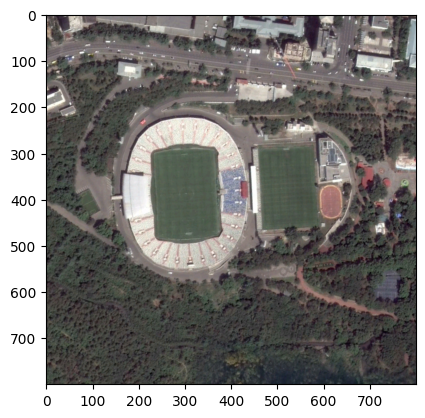

In [131]:
# cv2 compare with ovdsat for specific image
transform = transforms.Compose([
    transforms.Resize((602, 602)),
    Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

img_path = '/home/gridsan/manderson/ovdsat/data/dior/JPEGImages/06399.jpg' #12523.jpg 09249.jpg 04325.jpg
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
plt.imshow(img.permute(1, 2, 0))
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
img = transform(img)
print(img.shape)
print(img.mean())
print(img[:5,:5,:5])

In [132]:
images = img.unsqueeze(0)

patch_size = 14
num_tiles_side = 3
tile_size = 224
image_size = 602
B = len(images)
D = 768

# Create full image features tensor and a counter for aggregation
output_features = torch.zeros((B, image_size // patch_size, image_size // patch_size, D))
count_tensor = torch.zeros((B, image_size // patch_size, image_size // patch_size,))

# Process tiles through CLIP
with torch.no_grad():
    for i in range(num_tiles_side):
        for j in range(num_tiles_side):

            # Update tile coords
            start_i = i * tile_size
            start_j = j * tile_size
            end_i = min(start_i + tile_size, image_size)
            end_j = min(start_j + tile_size, image_size)

            # If tile exceeds, make new tile containing more image content
            if end_i - start_i < tile_size:
                start_i = end_i - tile_size
            if end_j - start_j < tile_size:
                start_j = end_j - tile_size

            # Extract the tile from the original image
            tile = images[:, :, start_i:end_i, start_j:end_j]

            # Get clip visual feats
            image_features = model.visual(tile).unsqueeze(1)
            print(image_features.shape)

            _, K, D = image_features.shape
            #print(K, D)
            p_w = p_h = int(K**0.5)
            #print(p_w, p_h)
            image_features = image_features.reshape(B, p_h, p_w, -1)  # Reshape to 2D
            #print(image_features.shape)

            #print(end_i // patch_size)
            # Add features to their location in the original image and track counts per location
            output_features[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += image_features
            count_tensor[:, start_i // patch_size:end_i // patch_size, start_j // patch_size:end_j // patch_size] += 1

# Average the overlapping patches
output_features /= count_tensor.unsqueeze(-1)

torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])
torch.Size([1, 1, 768])


In [275]:
print(output_features.shape)
print(output_features[0,:5,:5,0])
# At 16 we see it change so it replicates the 1x768 embedding for each 224x224 tile
print(output_features[0,15:20,15:20,0])
print(output_features[0,20:25,20:25,0])

torch.Size([1, 43, 43, 768])
tensor([[0.2825, 0.2825, 0.2825, 0.2825, 0.2825],
        [0.2825, 0.2825, 0.2825, 0.2825, 0.2825],
        [0.2825, 0.2825, 0.2825, 0.2825, 0.2825],
        [0.2825, 0.2825, 0.2825, 0.2825, 0.2825],
        [0.2825, 0.2825, 0.2825, 0.2825, 0.2825]])
tensor([[ 0.2825, -0.2594, -0.2594, -0.2594, -0.2594],
        [ 0.3435, -0.5583, -0.5583, -0.5583, -0.5583],
        [ 0.3435, -0.5583, -0.5583, -0.5583, -0.5583],
        [ 0.3435, -0.5583, -0.5583, -0.5583, -0.5583],
        [ 0.3435, -0.5583, -0.5583, -0.5583, -0.5583]])
tensor([[-0.5583, -0.5583, -0.5583, -0.5583, -0.5583],
        [-0.5583, -0.5583, -0.5583, -0.5583, -0.5583],
        [-0.5583, -0.5583, -0.5583, -0.5583, -0.5583],
        [-0.5583, -0.5583, -0.5583, -0.5583, -0.5583],
        [-0.5583, -0.5583, -0.5583, -0.5583, -0.5583]])


In [14]:
print(output_features[0,1,1,:10])
print(output_features[0,2,1,:10])
print(output_features[0,15,1,:10])
print(output_features[0,16,1,:10])

tensor([ 0.3910,  0.4319,  0.2748,  0.5947,  0.1700,  0.6805,  1.0916, -0.3914,
         0.3716, -0.0692])
tensor([ 0.3910,  0.4319,  0.2748,  0.5947,  0.1700,  0.6805,  1.0916, -0.3914,
         0.3716, -0.0692])
tensor([ 0.3910,  0.4319,  0.2748,  0.5947,  0.1700,  0.6805,  1.0916, -0.3914,
         0.3716, -0.0692])
tensor([ 0.2200, -0.6527,  0.2627,  0.2017, -0.0386,  0.2739,  1.0557, -0.4926,
        -0.0994,  0.1053])


In [133]:
feats = output_features.view(output_features.shape[0], -1, output_features.shape[-1])
print(feats.shape)

embeddings = text_norm
batch_size = 100

num_feats = feats.shape[0]
num_classes = embeddings.shape[0]
patch_2d_size = int(np.sqrt(feats.shape[1]))

cosim_list = []
for start_idx in range(0, num_classes, batch_size):
    print('start_idx')
    print(start_idx)
    end_idx = min(start_idx + batch_size, num_classes)
    print('end_idx')
    print(end_idx)

    embedding_batch = embeddings[start_idx:end_idx]  # Get a batch of embeddings
    print(embedding_batch.shape)

    ### Modified to exactly match CLIP cosine similarity in CoOp
    feat_norm = (feats / feats.norm(dim=-1, keepdim=True))
    embed_norm = embedding_batch / embedding_batch.norm(dim=-1, keepdim=True)

    print('debug image embedding norm mean')
    print(feat_norm.mean())

    print('debug text embedding norm mean')
    print(embed_norm.mean())

    feat_norm = feat_norm.float()
    embed_norm = embed_norm.float()

    dot_product = (feat_norm @ embed_norm.t())
    dot_product = dot_product.transpose(1, 2)

    dot_product *= model.logit_scale.exp()
    print('\ndot_product')
    print(dot_product.shape)

    # Append the similarity scores for this batch to the list
    cosim_list.append(dot_product)

# Concatenate the similarity scores from different batches
cosim = torch.cat(cosim_list, dim=1)

# Reshape to 2D and return class similarity maps
cosim = cosim.reshape(-1, num_classes, patch_2d_size, patch_2d_size)
print('cosim')
print(cosim.shape)

# Interpolate cosine similarity maps to original resolution
cosim = F.interpolate(cosim, size=602, mode='bicubic')
print(cosim.shape)

print(cosim[0,:5,:5,:5])

torch.Size([1, 1849, 768])
start_idx
0
end_idx
20
torch.Size([20, 768])
debug image embedding norm mean
tensor(7.4940e-05)
debug text embedding norm mean
tensor(-0.0004)

dot_product
torch.Size([1, 20, 1849])
cosim
torch.Size([1, 20, 43, 43])
torch.Size([1, 20, 602, 602])
tensor([[[ 3.9767,  3.9767,  3.9767,  3.9767,  3.9767],
         [ 3.9767,  3.9767,  3.9767,  3.9767,  3.9767],
         [ 3.9767,  3.9767,  3.9767,  3.9767,  3.9767],
         [ 3.9767,  3.9767,  3.9767,  3.9767,  3.9767],
         [ 3.9767,  3.9767,  3.9767,  3.9767,  3.9767]],

        [[ 4.5131,  4.5131,  4.5131,  4.5131,  4.5131],
         [ 4.5131,  4.5131,  4.5131,  4.5131,  4.5131],
         [ 4.5131,  4.5131,  4.5131,  4.5131,  4.5131],
         [ 4.5131,  4.5131,  4.5131,  4.5131,  4.5131],
         [ 4.5131,  4.5131,  4.5131,  4.5131,  4.5131]],

        [[ 7.5990,  7.5990,  7.5990,  7.5990,  7.5990],
         [ 7.5990,  7.5990,  7.5990,  7.5990,  7.5990],
         [ 7.5990,  7.5990,  7.5990,  7.5990,  7.59

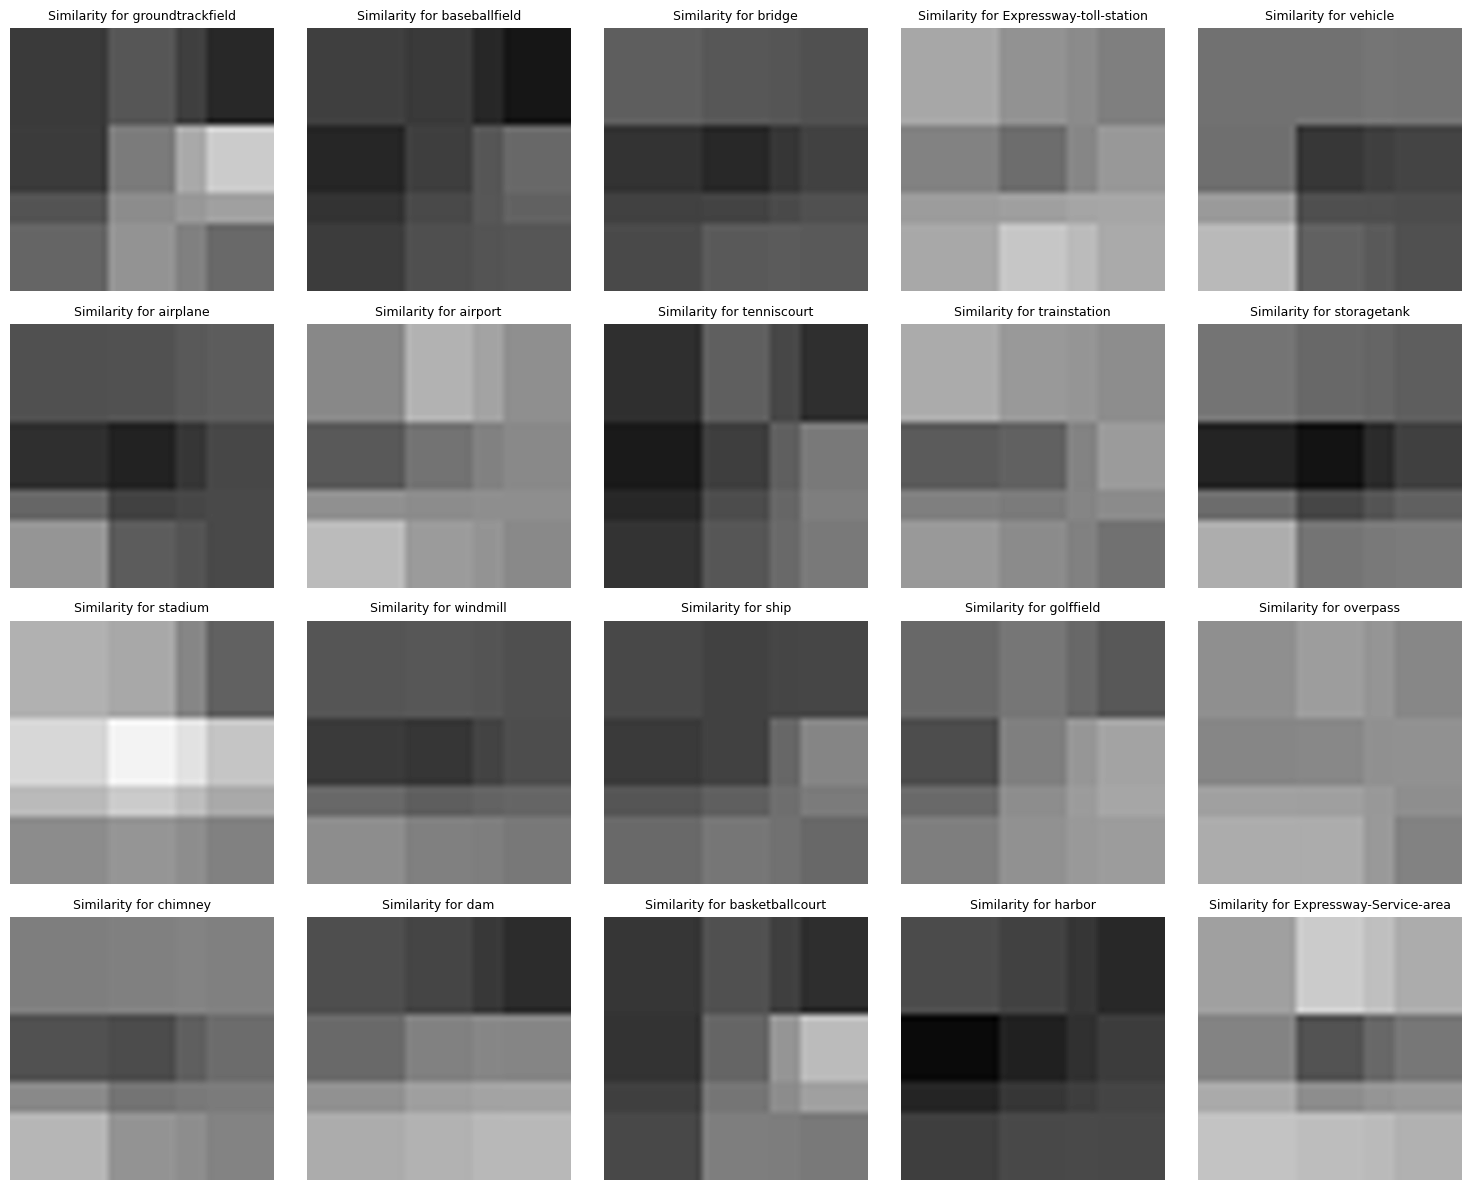

In [134]:
# Visualize cosim

# remove batch dimension -> [20, 602, 602]
maps = cosim.squeeze(0)  
num_channels = maps.shape[0]

# compute global min/max across all maps
global_min = maps.min().item()
global_max = maps.max().item()

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(num_channels):
    fmap = maps[i].detach().cpu().numpy()
    axes[i].imshow(fmap, cmap="gray", vmin=global_min, vmax=global_max)
    axes[i].set_title(f"Similarity for {coop_labels[i]}", fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [36]:
# # assume:
# #   img: torch.Tensor [3, 602, 602]  (original image, RGB, values 0–255 or 0–1)
# #   cosim: torch.Tensor [1, 20, 602, 602]

# # Convert image to HWC format for imshow
# img_np = img.permute(1, 2, 0).detach().cpu().numpy()
# img_vis = img_np.copy()
# img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

# # make sure it's in 0–1 range for plotting
# if img_np.max() > 1:
#     img_np = img_np / 255.0

# # drop batch dim
# maps = cosim.squeeze(0)  # [20, 602, 602]

# # Plot overlay for each channel
# fig, axes = plt.subplots(4, 5, figsize=(15, 12))
# axes = axes.flatten()

# for i in range(maps.shape[0]):
#     ax = axes[i]

#     # normalize map to 0–1
#     fmap = maps[i].detach().cpu().numpy()
#     #fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)

#     ax.imshow(img_vis)  # show original image
#     ax.imshow(fmap, cmap="viridis", alpha=0.5)  # overlay heatmap
#     ax.set_title(f"Similarity for {coop_labels[i]} (max: {fmap.max()})")
#     ax.axis("off")

# plt.tight_layout()
# plt.show()

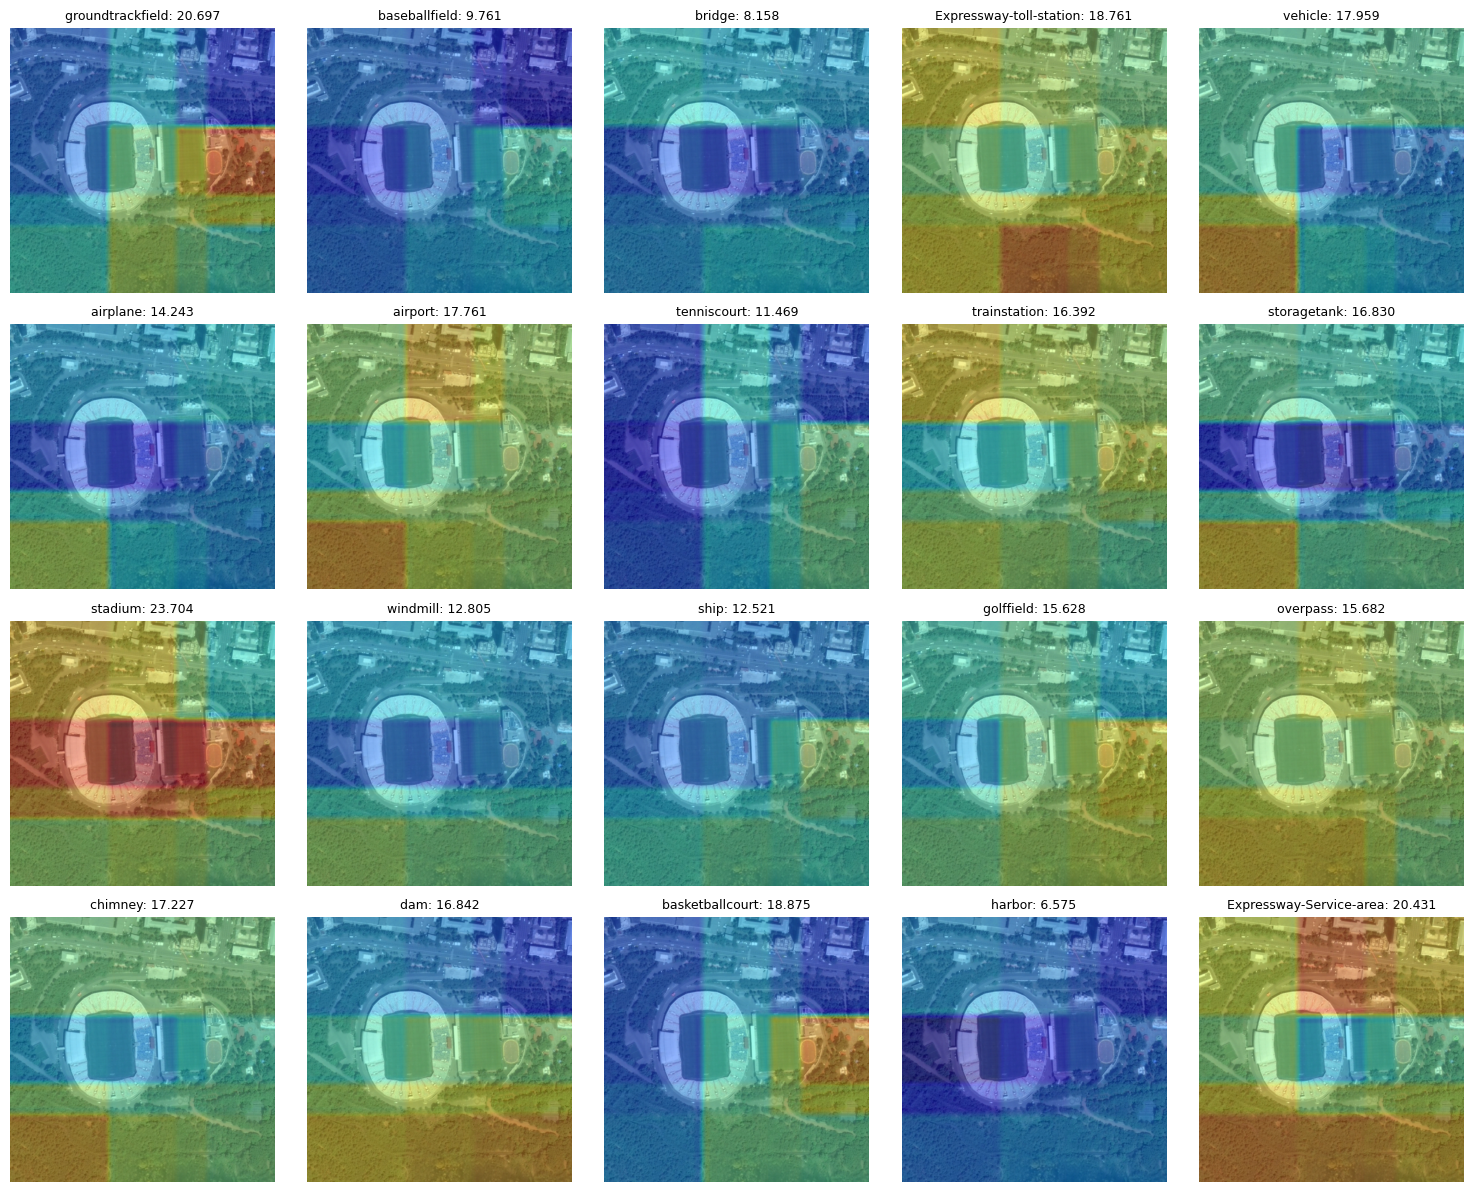

In [135]:
img_np = img.permute(1, 2, 0).detach().cpu().numpy()
img_vis = img_np.copy()
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

global_min = maps.min().item()
global_max = maps.max().item()

for i in range(maps.shape[0]):
    ax = axes[i]
    fmap = maps[i].detach().cpu().numpy()

    ax.imshow(img_vis)
    ax.imshow(fmap, cmap="jet", alpha=0.4, vmin=global_min, vmax=global_max)
    ax.set_title(f'{coop_labels[i]}: {fmap.max():.3f}' , fontsize=9)
    #ax.set_xlabel(f"max={fmap.max():.3f}", fontsize=7)
    ax.axis("off")

plt.tight_layout(pad=1.0)
plt.show()

In [107]:
# # Get proposal boxes
# from models.rpn.box_rpn import BoxRPN
# rpn_config='configs/FasterRCNN_FPN_DOTA_config.yaml'
# rpn_checkpoint='weights/FasterRCNN_FPN_DOTA_final_model.pth'
# rpn = BoxRPN(rpn_config, rpn_checkpoint)

# device = next(rpn.parameters()).device
# images = images.to(device)
# proposals, proposals_scores = rpn(images)

In [160]:
# print(proposals.shape)
# print(proposals_scores.shape)
# proposals_scores.mean() # all negative -> very low confidence

torch.Size([1, 1000, 4])
torch.Size([1, 1000])


tensor(-1.0829, device='cuda:0')

**Maybe this means that the image processing for the RPN needs to be what it was originally in ovdsat to work**

In [136]:
from models.rpn.box_rpn import BoxRPN
rpn_config='configs/FasterRCNN_FPN_DOTA_config.yaml'
rpn_checkpoint='weights/FasterRCNN_FPN_DOTA_final_model.pth'
rpn = BoxRPN(rpn_config, rpn_checkpoint)

# try loading like original
# cv2 compare with ovdsat for specific image
transform = transforms.Compose([
    transforms.Resize((602, 602)),
])

rpn_img = cv2.imread(img_path)
rpn_img = torch.as_tensor(rpn_img.astype("float32").transpose(2, 0, 1))
#plt.imshow(rpn_img.permute(1, 2, 0))
# print(img.shape)
# print(img.dtype)
# print(img.mean())
# print(img[:5,:5,:5])
rpn_img = transform(rpn_img)
print(rpn_img.shape)
print(rpn_img.mean())
print(rpn_img[:5,:5,:5])

torch.Size([3, 602, 602])
tensor(95.0408)
tensor([[[186.3635, 141.3358, 126.6850, 110.6850, 114.5581],
         [167.5592, 132.8066, 118.4809, 115.2381, 104.2759],
         [140.8737, 109.9528, 108.6227,  97.6647,  88.1964],
         [131.5103,  88.9549,  92.4541,  91.7061,  78.5357],
         [136.0812,  99.4376,  89.2885,  92.0617,  83.3796]],

        [[195.5953, 146.8447, 130.8335, 113.3578, 115.4725],
         [175.7369, 137.8332, 121.1763, 116.9470, 104.7560],
         [147.8577, 114.4727, 109.9782,  97.8155,  89.0712],
         [140.1814,  94.5494,  94.9607,  92.8115,  78.8319],
         [146.1136, 105.7004,  92.9534,  92.7266,  80.7488]],

        [[205.5683, 156.8536, 141.5365, 127.4075, 129.6436],
         [186.7103, 149.5499, 133.6563, 130.9510, 117.8224],
         [157.8392, 127.1329, 123.9782, 110.1173,  99.3216],
         [149.1814, 104.3869, 105.5341, 102.4635,  86.5973],
         [152.7132, 112.5370,  99.6056,  99.8270,  88.6499]]])


In [137]:
device = next(rpn.parameters()).device
rpn_img = rpn_img.unsqueeze(0).to(device)
proposals, proposals_scores = rpn(rpn_img)

In [138]:
print(proposals.shape)
print(proposals_scores.shape)

torch.Size([1, 1000, 4])
torch.Size([1, 1000])


In [139]:
print(proposals[0, :5])
print(proposals_scores[0, :5])

tensor([[340.3141, 217.8619, 443.1207, 362.6389],
        [161.0005, 200.5930, 289.9550, 373.2974],
        [140.2842, 168.3443, 322.6627, 385.1841],
        [448.7774, 283.2309, 478.9151, 331.0535],
        [444.0707, 276.3069, 487.0546, 333.2577]], device='cuda:0')
tensor([0.9316, 0.8900, 0.8514, 0.7011, 0.6561], device='cuda:0')


In [121]:
#proposals_scores

In [140]:
# From classifier

boxes = proposals
cosine_sim = cosim

cls = None
aggregation='mean'
num_classes = len(coop_labels)

# Gather similarity values inside each box and compute average box similarity
box_similarities = []
B = images.shape[0]
for b in range(B):
    image_boxes = boxes[b][:, :4]

    image_similarities = []
    count = 0
    for i, box in enumerate(image_boxes):
        x_min, y_min, x_max, y_max = box.int()

        # if cls is not None:
        #     if (x_min < 0 or
        #         y_min < 0 or
        #         y_max > self.target_size[0] or
        #         x_max > self.target_size[0] or
        #         y_max - y_min < self.min_box_size or
        #         x_max - x_min < self.min_box_size):
        #         count += 1
        #         cls[b][i] = self.ignore_index   # If invalid box, assign the label to ignore it while computing the loss
        #         image_similarities.append(torch.zeros(self.num_classes, device=images.device))
        #         continue

        if aggregation == 'mean':
            box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max].mean(dim=[1, 2])
        elif aggregation == 'max':
            _,n,h,w = cosine_sim.shape
            box_sim, _ = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1).max(dim=1)
        elif aggregation == 'topk':
            _,n,h,w = cosine_sim.shape
            box_sim = cosine_sim[b, :, y_min:y_max - 1, x_min:x_max - 1].reshape(n, -1)
            topk = k if k <= box_sim.shape[1] else box_sim.shape[1]
            box_sim, _ = box_sim.topk(topk, dim=1)
            box_sim = box_sim.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation method')

        has_nan = torch.isnan(box_sim).any().item()
        image_similarities.append(box_sim)

    box_similarities.append(torch.stack(image_similarities))

box_similarities = torch.stack(box_similarities)  # Shape: [B, max_boxes, N]

# Flatten box_logits and target_labels
box_similarities = box_similarities.view(B, -1, num_classes)

In [141]:
print(boxes[0,0])
print(box_similarities.shape)
box_similarities[0,0]

tensor([340.3141, 217.8619, 443.1207, 362.6389], device='cuda:0')
torch.Size([1, 1000, 20])


tensor([12.9854,  5.7481,  3.2104, 10.7324,  4.4544,  3.0086, 10.7550,  6.4076,
        10.1415,  1.8468, 21.0793,  4.5034,  6.9680, 12.2049, 12.3315,  7.1077,
        11.1003, 11.0288,  2.4827,  8.1850], grad_fn=<SelectBackward0>)

In [27]:
# # Try specific box

# x_min = 263
# y_min = 65
# x_max = 602
# y_max = 466

# box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max]
# print(box_sim.shape)

# box_sim = box_sim.mean(dim=[1, 2])
# print(box_sim.shape)

# print(box_sim)

In [42]:
# boxes + viz (don't need to run)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

box_similarities = []
B = images.shape[0]

for b in range(B):
    image_boxes = boxes[b][:, :4]
    img_np = images[b].permute(1, 2, 0).detach().cpu().numpy()
    if img_np.max() > 1:  # normalize if 0–255
        img_np = img_np / 255.0

    image_similarities = []
    for i, box in enumerate(image_boxes):
        x_min, y_min, x_max, y_max = [int(v.item()) for v in box]

        # --- your aggregation logic ---
        if aggregation == 'mean':
            box_sim = cosine_sim[b, :, y_min:y_max, x_min:x_max].mean(dim=[1, 2])
        elif aggregation == 'max':
            _, n, h, w = cosine_sim.shape
            box_sim, _ = cosine_sim[b, :, y_min:y_max, x_min:x_max].reshape(n, -1).max(dim=1)
        elif aggregation == 'topk':
            _, n, h, w = cosine_sim.shape
            region = cosine_sim[b, :, y_min:y_max, x_min:x_max].reshape(n, -1)
            topk = min(k, region.shape[1])
            box_sim, _ = region.topk(topk, dim=1)
            box_sim = box_sim.mean(dim=1)
        else:
            raise ValueError('Invalid aggregation method')

        image_similarities.append(box_sim)
        
        print(f"Box {i}: ({x_min}, {y_min}, {x_max}, {y_max}) -> {label} ({score:.3f})")

        # --- visualization: show this box on its own ---
        max_score, best_class = torch.max(box_sim, dim=0)
        label = coop_labels[best_class.item()]
        score = max_score.item()

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(img_vis)

        # draw rectangle
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # add label + score
        ax.text(
            x_min, max(y_min - 5, 0),
            f"{label}: {score:.2f}",
            color="yellow", fontsize=8, weight="bold",
            bbox=dict(facecolor="black", alpha=0.5, pad=1)
        )
        plt.show()

    box_similarities.append(torch.stack(image_similarities))

box_similarities = torch.stack(box_similarities)  # [B, max_boxes, N]


NameError: name 'label' is not defined

In [93]:
def filter_boxes(boxes, classes, scores, target_size, num_labels, box_conf_threshold=0):
    print(box_conf_threshold)
    
    print('in filter_boxes')
    target_height, target_width = target_size
    keep = ((boxes[:, 0] >= 0) & (boxes[:, 1] >= 0) &
            (boxes[:, 2] <= target_width) & (boxes[:, 3] <= target_height))
    
    print(boxes.shape)

    filtered_boxes = boxes[keep]
    filtered_classes = classes[keep]
    filtered_scores = scores[keep]
    
    print(filtered_boxes.shape)

    # Filter out boxes classified as background
    predictions = torch.argmax(filtered_classes, dim=-1)   
    #print(predictions.shape)
    filtered_boxes = filtered_boxes[predictions < num_labels, ...]
    filtered_classes = filtered_classes[predictions < num_labels, ...]
    filtered_scores = filtered_scores[predictions < num_labels]
    
    print(filtered_boxes.shape)
    
    # Filter out boxes with low confidence
    keep = filtered_scores > box_conf_threshold
    filtered_boxes = filtered_boxes[keep, ...]
    filtered_classes = filtered_classes[keep, ...]
    filtered_scores = filtered_scores[keep]
    
    print(filtered_boxes.shape)
    
    print('done')


    return filtered_boxes, filtered_classes[:, :num_labels], filtered_scores

In [142]:
#0.001 0.2 300
import time
import torchvision

def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nm=0,  # number of masks
        isdino=True,
):
    """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """
    
    print('NMS debug')
    print(conf_thres, iou_thres, max_det)

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = prediction.shape[2] - nm - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    max_wh = 7680  # (pixels) maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 0.5 + 0.05 * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    mi = 5 + nc  # mask start index
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(lb)), lb[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        #if not isdino:
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box/Mask
        if isdino:
            box = x[:, :4]
        else:
            box = xywh2xyxy(x[:, :4])  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        
        mask = x[:, mi:]  # zero columns if no masks

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:mi] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 5 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            print('in best class only')
            conf, j = x[:, 5:mi].max(1, keepdim=True)
            print(conf.shape)
            # CHANGE conf_thres
            conf_thres = 10
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres]
            print(x.shape)

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            #LOGGER.warning(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            break  # time limit exceeded

    return output

In [143]:
# From detector

#from utils_dir.processing_utils import filter_boxes
#from utils_dir.nms import non_max_suppression

target_size = (602,602)
num_classes = 20
box_conf_threshold = 0.01
iou_thr = 0.2
conf_thres = 0.001

B, num_proposals = proposals_scores.shape
preds = box_similarities

# if num_proposals == 0:
#     return [torch.tensor([], device=images.device) for _ in range(B)]

# Extract class scores and predicted classes
preds = preds.reshape(B, num_proposals, -1)
print(preds.shape)
scores, _ = torch.max(preds, dim=-1)
print(scores.shape)
classes = torch.argmax(preds, dim=-1)
print(classes.shape)

# Filter predictions and prepare for NMS
processed_predictions = []
for b in range(B):
    # Filter and prepare boxes for NMS
    filtered_boxes, filtered_classes, filtered_scores = filter_boxes(proposals[b].cpu(),
                                                                    preds[b].cpu(),
                                                                    proposals_scores[b].cpu(),
                                                                    target_size,
                                                                    num_classes,
                                                                    box_conf_threshold)
    print('debug')
    print(filtered_boxes[0])
    pred_boxes_with_scores = torch.cat([filtered_boxes, filtered_scores[:, None], filtered_classes], dim=1)

    # Use the cosine similarity class score as box confidence scores
    max_cls_scores, _ = torch.max(filtered_classes, dim=-1)
    sorted_indices = torch.argsort(filtered_scores, descending=True)
    pred_boxes_with_scores = pred_boxes_with_scores[sorted_indices]

    # Apply non maximum suppression
    nms_results = non_max_suppression(pred_boxes_with_scores.unsqueeze(0), iou_thres=iou_thr, conf_thres=conf_thres) 
    # In NMS it takes object conf * class conf!!!
    processed_predictions.append(nms_results[0])

torch.Size([1, 1000, 20])
torch.Size([1, 1000])
torch.Size([1, 1000])
0.01
in filter_boxes
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([1000, 4])
torch.Size([39, 4])
done
debug
tensor([340.3141, 217.8619, 443.1207, 362.6389])
NMS debug
0.001 0.2 300
in best class only
torch.Size([39, 1])
torch.Size([5, 6])


In [144]:
print(pred_boxes_with_scores[0]) # matches!
print()
print(processed_predictions)

tensor([340.3141, 217.8619, 443.1207, 362.6389,   0.9316,  12.9854,   5.7481,
          3.2104,  10.7324,   4.4544,   3.0086,  10.7550,   6.4076,  10.1415,
          1.8468,  21.0793,   4.5034,   6.9680,  12.2049,  12.3315,   7.1077,
         11.1003,  11.0288,   2.4827,   8.1850], grad_fn=<SelectBackward0>)

[tensor([[340.3141, 217.8619, 443.1207, 362.6389,  19.6374,  10.0000],
        [161.0005, 200.5930, 289.9550, 373.2974,  18.0851,  10.0000],
        [448.7774, 283.2309, 478.9151, 331.0535,  12.8729,   0.0000]],
       grad_fn=<IndexBackward0>)]


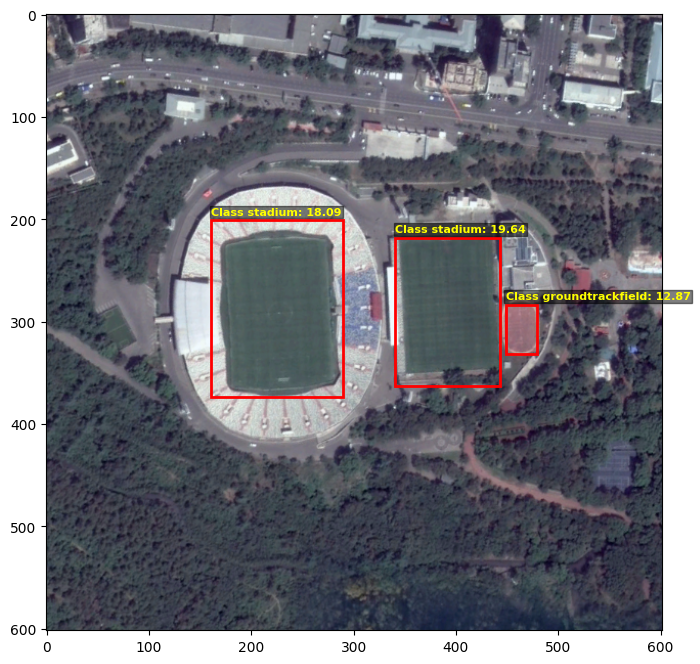

In [145]:
preds = processed_predictions[0].detach().cpu()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_vis)

for box in preds:
    x1, y1, x2, y2, score, label = box.tolist()

    # draw rectangle
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # add label and score
    ax.text(
        x1, max(y1 - 5, 0),
        f"Class {coop_labels[int(label)]}: {score:.2f}",
        color="yellow", fontsize=8, weight="bold",
        bbox=dict(facecolor="black", alpha=0.5, pad=1)
    )

plt.show()

### Random image

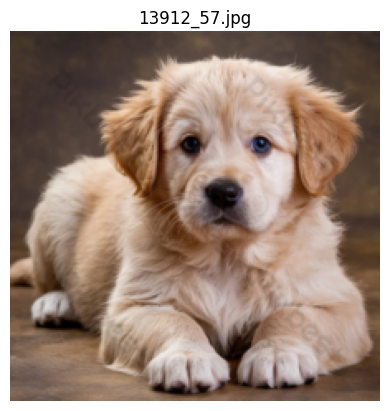

tensor([-0.0975,  0.5657, -0.0613, -0.9503, -0.0720, -0.3698,  0.5088, -0.3197,
         0.5018, -0.3761])
torch.Size([1, 768])
torch.Size([20, 768])
tensor([0.7775, 0.7929, 0.7892, 0.6253, 0.8011, 0.6203, 0.6670, 0.8551, 0.6977,
        0.7897, 0.6988, 0.6191, 0.7204, 0.6678, 0.6462, 0.6411, 0.7077, 0.8188,
        0.6239, 0.5075])
torch.Size([1, 20])
torch.Size([20])

For Expressway-Service-area: Max cosine similarity label is tenniscourt
  groundtrackfield: 0.7775001525878906
  baseballfield: 0.7929238080978394
  bridge: 0.7891579270362854
  Expressway-toll-station: 0.6253425478935242
  vehicle: 0.8010638952255249
  airplane: 0.6203119158744812
  airport: 0.6669644117355347
  tenniscourt: 0.8551042675971985
  trainstation: 0.697674036026001
  storagetank: 0.7897009253501892
  stadium: 0.6987547874450684
  windmill: 0.6191170811653137
  ship: 0.7203819155693054
  golffield: 0.66778564453125
  overpass: 0.6461727619171143
  chimney: 0.6410844326019287
  dam: 0.7076675891876221
  baske

In [8]:
# Try random image
with torch.no_grad():
    #label_dir = f"{crop_dir}/{label}"
    img_path = '/home/gridsan/manderson/ovdsat/data/dog.jpg'
    img = transform(Image.open(img_path).convert("RGB")).unsqueeze(0)

    # --- for visualization only ---
    to_show = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # [H,W,3]
    plt.imshow(to_show)
    plt.title(fname)
    plt.axis("off")
    plt.show()
    # --- end visualization ---

    imgs = prepare_image_for_backbone(img, "remoteclip-14")

    # Extract features for all 5 images
    img_feats = model.visual(imgs)                  # [5, 768]
    if img_feats.ndim > 2:
        img_feats = img_feats.squeeze()

    print(img_feats[0,:10])

    # Normalize
    img_norm = img_feats / img_feats.norm(dim=-1, keepdim=True)         # [5, 768]
    print(img_norm.shape)
    text_norm = coop_text_prot / coop_text_prot.norm(dim=-1, keepdim=True)  # [20, 768]
    print(text_norm.shape)

    # Cosine similarity: images vs all prototypes
    sim_mat = model.logit_scale * img_norm @ text_norm.T   # [5, 20]
    print(sim_mat[0])
    print(sim_mat.shape)

    # Average across the 5 images
    avg_sim = sim_mat.mean(dim=0)        # [20]
    print(avg_sim.shape)

    # Print nicely for this label
    print(f"\nFor {label}: Max cosine similarity label is {coop_labels[np.argmax(avg_sim)]}")
    for j, val in enumerate(avg_sim):
        proto_name = coop_labels[j] if j < len(coop_labels) else f"proto_{j}"
        print(f"  {proto_name}: {val.item()}")

In [13]:
# Compare PIL and cv2 loading

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD),
])

img_path = '/home/gridsan/manderson/ovdsat/data/dog.jpg'

# PIL
img = Image.open(img_path).convert("RGB")
to_tensor = transforms.ToTensor()
img = to_tensor(img)
print(img.shape)
print(img.dtype)
print(img.mean())
print(img[:5,:5,:5])
img = transform(img).unsqueeze(0)
print(img.mean())
print()

# cv2
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1)) / 255.0
print(img.shape)
print(img.dtype)
print(img.mean())
print(img[:5,:5,:5])
img = transform(img).unsqueeze(0)
print(img.mean())

torch.Size([3, 700, 700])
torch.float32
tensor(0.4758)
tensor([[[0.3255, 0.3255, 0.3255, 0.3255, 0.3255],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
         [0.2235, 0.2235, 0.2235, 0.2235, 0.2235],
         [0.2235, 0.2235, 0.2235, 0.2235, 0.2235],
         [0.2235, 0.2235, 0.2235, 0.2196, 0.2196]],

        [[0.2824, 0.2824, 0.2824, 0.2824, 0.2824],
         [0.1608, 0.1608, 0.1608, 0.1608, 0.1608],
         [0.1843, 0.1843, 0.1843, 0.1843, 0.1843],
         [0.1843, 0.1843, 0.1843, 0.1843, 0.1843],
         [0.1843, 0.1843, 0.1843, 0.1804, 0.1804]],

        [[0.2510, 0.2510, 0.2510, 0.2510, 0.2510],
         [0.1294, 0.1294, 0.1294, 0.1294, 0.1294],
         [0.1529, 0.1529, 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529, 0.1529, 0.1529],
         [0.1529, 0.1529, 0.1529, 0.1490, 0.1490]]])
tensor(0.0984)

torch.Size([3, 700, 700])
torch.float32
tensor(0.4758)
tensor([[[0.3255, 0.3255, 0.3255, 0.3255, 0.3255],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
 

In [33]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB

# resize explicitly (cv2 resize)
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)

# convert to torch tensor, scale to [0,1]
img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0

# normalize
normalize = transforms.Normalize(mean=PIXEL_MEAN, std=PIXEL_STD)
img = normalize(img).unsqueeze(0)
print(img.mean())

tensor(0.0969)


In [41]:
model.logit_scale

Parameter containing:
tensor(4.6028, requires_grad=True)

### Create Eurosat json

In [8]:
import pandas as pd
import json

# Load CSV files
train_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/train.csv")
train_df.reset_index(drop=True, inplace=True) 
val_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/validation.csv")
val_df.reset_index(drop=True, inplace=True) 
test_df = pd.read_csv("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/test.csv")
test_df.reset_index(drop=True, inplace=True) 

# Remove columns that are unnamed or have 'Unnamed' in their names
train_df = train_df.loc[:, ~train_df.columns.str.contains('^Unnamed')]
val_df = val_df.loc[:, ~val_df.columns.str.contains('^Unnamed')]
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]

# Ensure the column names are consistent with the expected format (impath, label, classname)
train_df.columns = ['impath', 'label', 'classname']
val_df.columns = ['impath', 'label', 'classname']
test_df.columns = ['impath', 'label', 'classname']

# Convert DataFrames to list of lists
train_data = train_df.values.tolist()
val_data = val_df.values.tolist()
test_data = test_df.values.tolist()

# Combine into one dictionary
dataset = {
    "train": train_data,
    "val": val_data,
    "test": test_data
}

# Save as JSON
with open("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/dataset.json", "w") as json_file:
    json.dump(dataset, json_file, indent=4)

print("JSON file saved")

JSON file saved


In [9]:
from dassl.utils import read_json

split = read_json("/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/dataset.json")

In [10]:
train_split = split['train']

In [11]:
train_split[0]

['AnnualCrop/AnnualCrop_142.jpg', 0, 'AnnualCrop']

In [12]:
i = 0
for impath, label, classname in train_split:
    if i < 1:
        print(impath, label, classname)
    else:
        break
    i += 1

AnnualCrop/AnnualCrop_142.jpg 0 AnnualCrop


In [14]:
from transformers import CLIPModel

/home/gridsan/manderson/.conda/envs/dassl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gridsan/manderson/.conda/envs/dassl/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gridsan/manderson/.conda/envs/da

In [15]:
model = CLIPModel.from_pretrained('/home/gridsan/manderson/ovdsat/weights/clip-vit-large-patch14')

In [17]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

### Convert dassl datums to csv splits

In [21]:
import pickle
import pandas as pd
import os
import glob

In [4]:
with open('/home/gridsan/manderson/ovdsat/data/eurosat/split_fewshot/shot_1-seed_1.pkl', 'rb') as f:
    data = pickle.load(f)
    
data # has train and val

{'train': [<dassl.data.datasets.base_dataset.Datum at 0x7fa0cc85ba60>,
 'val': [<dassl.data.datasets.base_dataset.Datum at 0x7fa0cc74f430>,
  <dassl.data.datasets.base_dataset.Datum at 0x7f9f7e9139d0>]}

In [11]:
print(data['train'][0]._impath)
print(data['train'][0]._label)
print(data['train'][0]._classname)

/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/AnnualCrop/AnnualCrop_832.jpg
0
AnnualCrop


In [24]:
# Function to process a .pkl file and save train/val sets as CSV
def convert_pkl_to_csv(pkl_path):
    # Extract shot and seed from filename (assumes format: shot_X-seed_Y.pkl)
    filename = os.path.basename(pkl_path).replace(".pkl", "")
    print(filename)
    
    # Load the .pkl file
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    
    # Extract train and validation sets
    train_set = data.get("train", [])  # Default to empty list if missing
    val_set = data.get("val", [])  # Default to empty list if missing
    
    # Function to extract relevant attributes from datum objects
    def extract_data(dataset):
        return [{"Filename": d._impath, "Label": d._label, "ClassName": d._classname} for d in dataset]
    
    # Convert to DataFrame
    train_df = pd.DataFrame(extract_data(train_set))
    val_df = pd.DataFrame(extract_data(val_set))

    # Save to CSV
    train_csv_path = f"{pkl_path[:-4]}-train.csv"
    val_csv_path = f"{pkl_path[:-4]}-val.csv"
    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    
    print(f"Saved: {train_csv_path}, {val_csv_path}")

In [25]:
# Directory path
dir_path = "/home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot"

# Find all .pkl files in the directory
pkl_files = glob.glob(f"{dir_path}/*.pkl")

for pkl_file in pkl_files:
    convert_pkl_to_csv(pkl_file)

shot_2-seed_5
Saved: /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_2-seed_5-train.csv, /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_2-seed_5-val.csv
shot_1-seed_3
Saved: /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_1-seed_3-train.csv, /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_1-seed_3-val.csv
shot_4-seed_1
Saved: /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_4-seed_1-train.csv, /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_4-seed_1-val.csv
shot_4-seed_5
Saved: /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_4-seed_5-train.csv, /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_4-seed_5-val.csv
shot_2-seed_1
Saved: /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_2-seed_1-train.csv, /home/gridsan/manderson/ovdsat/data/eurosat/EuroSAT/split_fewshot/shot_2-seed_1-val.csv
